In [62]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics
#import lightgbm as lgb
#import xgboost as xgb

from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from fastai.structured import *
from fastai.column_data import *
PATH = 'data/'

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

# 1.Feature Engineering Function

In [63]:
PATH = 'data/'

#the columns that will be parsed to extract the fields from the jsons
cols_to_parse = ['device', 'geoNetwork', 'totals', 'trafficSource']
def read_parse_dataframe(file_name):
    #full path for the data file
    path = PATH + file_name
    #read the data file, convert the columns in the list of columns to parse using json loader,
    #convert the `fullVisitorId` field as a string
    data_df = pd.read_csv(path, 
        converters={column: json.loads for column in cols_to_parse}, 
        dtype={'fullVisitorId': 'str'})
    #parse the json-type columns
    for col in cols_to_parse:
        #each column became a dataset, with the columns the fields of the Json type object
        json_col_df = json_normalize(data_df[col])
        json_col_df.columns = [f"{col}_{sub_col}" for sub_col in json_col_df.columns]
        #we drop the object column processed and we add the columns created from the json fields
        data_df = data_df.drop(col, axis=1).merge(json_col_df, right_index=True, left_index=True)
    return data_df

def process_date_time(data_df):
    print("process date time ...")
    data_df['date'] = data_df['date'].astype(str)
    data_df["date"] = data_df["date"].apply(lambda x : x[:4] + "-" + x[4:6] + "-" + x[6:])
    data_df["date"] = pd.to_datetime(data_df["date"])   
    data_df["year"] = data_df['date'].dt.year
    data_df["month"] = data_df['date'].dt.month
    data_df["day"] = data_df['date'].dt.day
    data_df["weekday"] = data_df['date'].dt.weekday
    data_df['weekofyear'] = data_df['date'].dt.weekofyear
    data_df['month_unique_user_count'] = data_df.groupby('month')['fullVisitorId'].transform('nunique')
    data_df['day_unique_user_count'] = data_df.groupby('day')['fullVisitorId'].transform('nunique')
    data_df['weekday_unique_user_count'] = data_df.groupby('weekday')['fullVisitorId'].transform('nunique')
    return data_df

def process_format(data_df):
    print("process format ...")
    for col in ['visitNumber', 'totals_hits', 'totals_pageviews']:
        data_df[col] = data_df[col].astype(float)
    data_df['trafficSource_adwordsClickInfo.isVideoAd'].fillna(True, inplace=True)
    data_df['trafficSource_isTrueDirect'].fillna(False, inplace=True)
    return data_df
    
def process_device(data_df):
    print("process device ...")
    data_df['browser_category'] = data_df['device_browser'] + '_' + data_df['device_deviceCategory']
    data_df['browser_operatingSystem'] = data_df['device_browser'] + '_' + data_df['device_operatingSystem']
    data_df['source_country'] = data_df['trafficSource_source'] + '_' + data_df['geoNetwork_country']
    return data_df

def process_totals(data_df):
    print("process totals ...")
    data_df['visitNumber'] = np.log1p(data_df['visitNumber'])
    data_df['totals_hits'] = np.log1p(data_df['totals_hits'])
    data_df['totals_pageviews'] = np.log1p(data_df['totals_pageviews'].fillna(0))
    data_df['mean_hits_per_day'] = data_df.groupby(['day'])['totals_hits'].transform('mean')
    data_df['sum_hits_per_day'] = data_df.groupby(['day'])['totals_hits'].transform('sum')
    data_df['max_hits_per_day'] = data_df.groupby(['day'])['totals_hits'].transform('max')
    data_df['min_hits_per_day'] = data_df.groupby(['day'])['totals_hits'].transform('min')
    data_df['var_hits_per_day'] = data_df.groupby(['day'])['totals_hits'].transform('var')
    return data_df

def process_geo_network(data_df):
    print("process geo network ...")
    data_df['sum_pageviews_per_network_domain'] = data_df.groupby('geoNetwork_networkDomain')['totals_pageviews'].transform('sum')
    data_df['count_pageviews_per_network_domain'] = data_df.groupby('geoNetwork_networkDomain')['totals_pageviews'].transform('count')
    data_df['mean_pageviews_per_network_domain'] = data_df.groupby('geoNetwork_networkDomain')['totals_pageviews'].transform('mean')
    data_df['sum_hits_per_network_domain'] = data_df.groupby('geoNetwork_networkDomain')['totals_hits'].transform('sum')
    data_df['count_hits_per_network_domain'] = data_df.groupby('geoNetwork_networkDomain')['totals_hits'].transform('count')
    data_df['mean_hits_per_network_domain'] = data_df.groupby('geoNetwork_networkDomain')['totals_hits'].transform('mean')
    return data_df

## 2.Load data

In [64]:
train_df = read_parse_dataframe('train.csv')
train_df = process_date_time(train_df)
test_df = read_parse_dataframe('test.csv')
test_df = process_date_time(test_df)

process date time ...
process date time ...


# 3.Drop columns

In [65]:
cols_to_drop = [col for col in train_df.columns if train_df[col].nunique(dropna=False) == 1]
train_df.drop(cols_to_drop, axis=1, inplace=True)
test_df.drop([col for col in cols_to_drop if col in test_df.columns], axis=1, inplace=True)

## 4.Only one not null value

In [66]:
train_df.drop(['trafficSource_campaignCode'], axis=1, inplace=True)

## 5.Converting columns format

In [67]:
train_df['totals_transactionRevenue'] = train_df['totals_transactionRevenue'].astype(float)
train_df['totals_transactionRevenue'] = train_df['totals_transactionRevenue'].fillna(0)
train_df['totals_transactionRevenue'] = np.log1p(train_df['totals_transactionRevenue'])

## 6.Features engineering

In [68]:
train_df = process_format(train_df)
train_df = process_device(train_df)
train_df = process_totals(train_df)
train_df = process_geo_network(train_df)

test_df = process_format(test_df)
test_df = process_device(test_df)
test_df = process_totals(test_df)
test_df = process_geo_network(test_df)

process format ...
process device ...
process totals ...
process geo network ...
process format ...
process device ...
process totals ...
process geo network ...


## Splitting Data into Categorical/Numerical

In [69]:
col_x = ['sum_pageviews_per_network_domain', 'sum_hits_per_network_domain',
       'mean_hits_per_network_domain',
       'mean_pageviews_per_network_domain', 'totals_hits',
       'totals_pageviews']

for i in col_x:
    train_df[i+'_square'] =  train_df[i] ** 2
    test_df[i+'_square']  = test_df[i] ** 2

num_cols = ['month_unique_user_count', 'day_unique_user_count', 'weekday_unique_user_count',
            'totals_hits', 'totals_pageviews', 
            'mean_hits_per_day', 'sum_hits_per_day', 'max_hits_per_day', 'var_hits_per_day',
            'sum_pageviews_per_network_domain', 'count_pageviews_per_network_domain', 'mean_pageviews_per_network_domain',
            'sum_hits_per_network_domain', 'count_hits_per_network_domain', 'mean_hits_per_network_domain',
            'sum_pageviews_per_network_domain_square', 'sum_hits_per_network_domain_square', 'mean_hits_per_network_domain_square', 
            'mean_pageviews_per_network_domain_square', 'totals_hits_square', 'totals_pageviews_square']
            
not_used_cols = ["visitNumber", "fullVisitorId", "sessionId", "min_hits_per_day",
        "visitId", "visitStartTime", 'trafficSource_referralPath', "date", "fullVisitorId", 'totals_transactionRevenue']
cat_cols = [col for col in train_df.columns if col not in num_cols and col not in not_used_cols]

In [70]:
train_df.shape, test_df.shape, len(num_cols) + len(cat_cols)

((903653, 63), (804684, 62), 54)

# 8.Data Prepare For Modeling

In [71]:
# Model
print("prepare model ...")
train_df = train_df.sort_values('date')
dep = 'totals_transactionRevenue'
test_df[dep] = 0
X = train_df[cat_cols + num_cols + [dep, 'date']].copy()
X_test = test_df[cat_cols + num_cols + [dep, 'date', 'fullVisitorId']].copy()


prepare model ...


In [72]:
X.shape, X_test.shape, len(num_cols) + len(cat_cols)

((903653, 56), (804684, 57), 54)

In [73]:
print("Number of unique visitors in train set : ",train_df.fullVisitorId.nunique(), " out of rows : ",train_df.shape[0])
print("Number of unique visitors in train set : ",test_df.fullVisitorId.nunique(), " out of rows : ",test_df.shape[0])
print("Number of common visitors in train and test set : ",len(set(train_df.fullVisitorId.unique()).intersection(set(test_df.fullVisitorId.unique())) ))

Number of unique visitors in train set :  714167  out of rows :  903653
Number of unique visitors in train set :  617242  out of rows :  804684
Number of common visitors in train and test set :  7679


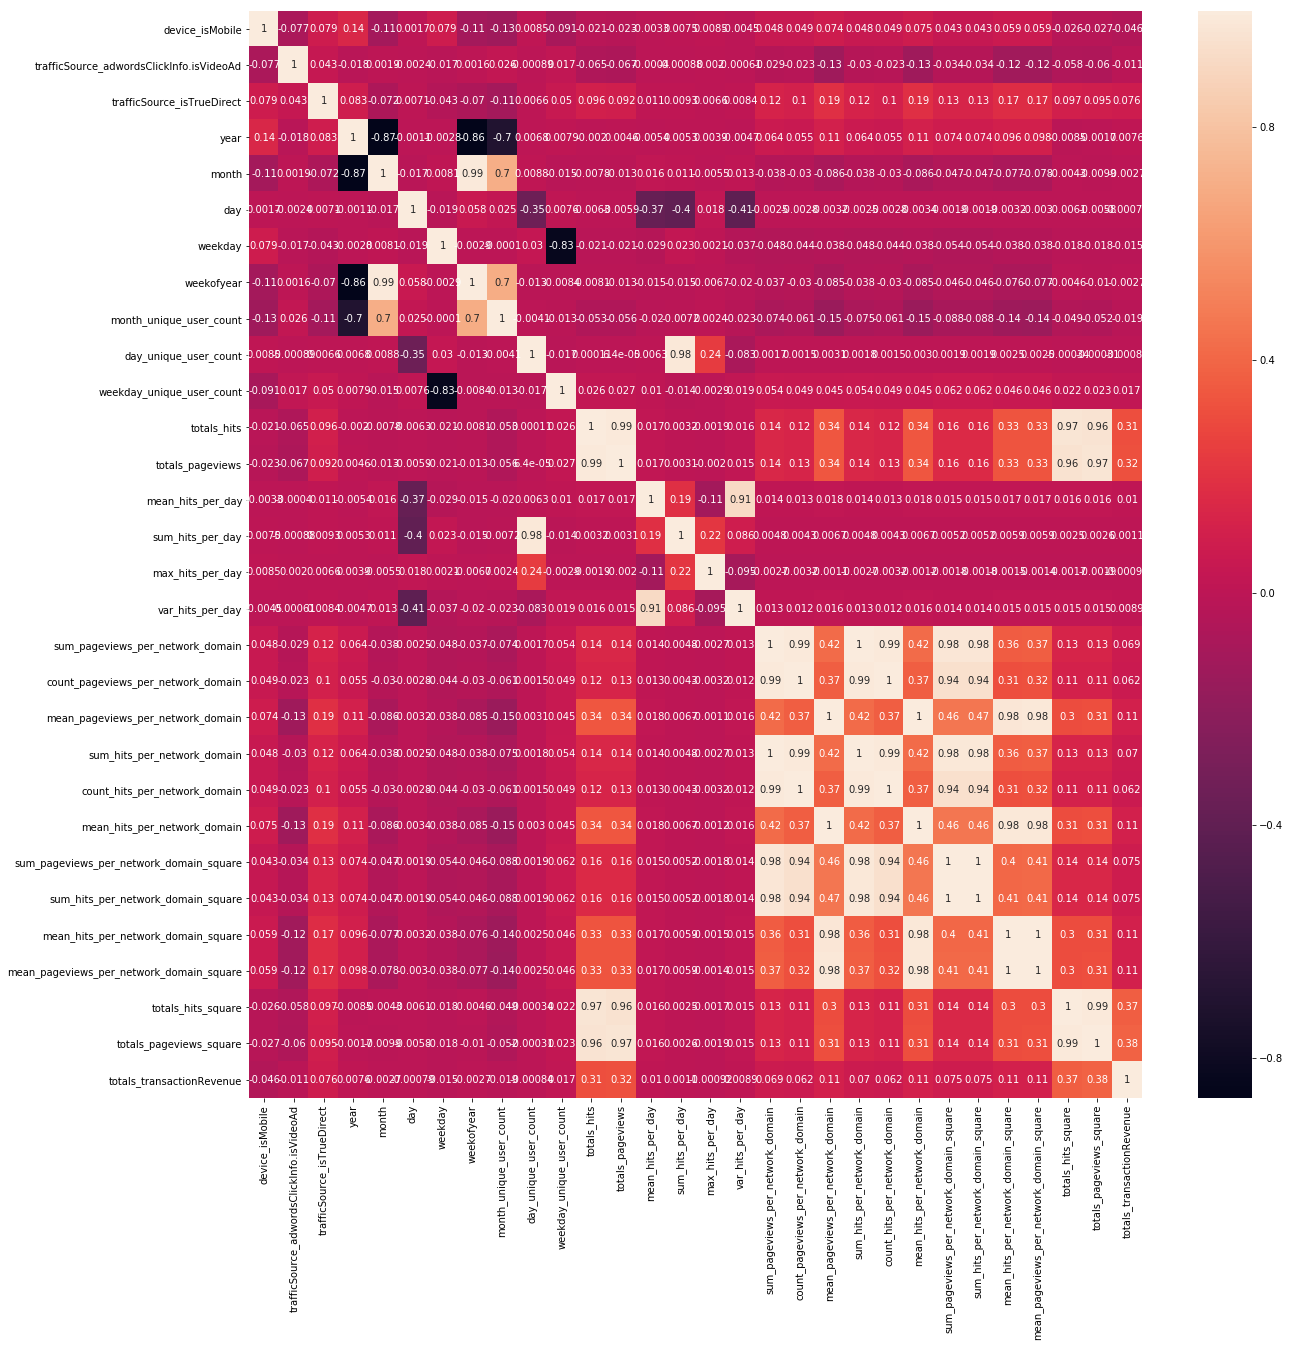

In [74]:
plt.figure(figsize=(20,20))
sns.heatmap(X.corr(),annot=True)

### Correlation coefficient of the variables

In [75]:
print("Variables not in test but in train : ", set(X.columns).difference(set(X_test.columns)))

Variables not in test but in train :  set()


In [76]:
print("Variables not in train but in test : ", set(X_test.columns).difference(set(X.columns)))

Variables not in train but in test :  {'fullVisitorId'}


In [77]:
X.to_pickle("train_df")
X_test.to_pickle("test_df")

In [ ]:
X = pd.read_pickle("train_df")
X_test = pd.read_pickle("test_df")

In [78]:
len(X.columns), len(X_test.columns)

(56, 57)

In [57]:
'''num_cols = ['month_unique_user_count', 'day_unique_user_count', 'weekday_unique_user_count',
            'totals_hits', 'totals_pageviews', 'mean_hits_per_day', 'sum_hits_per_day', 'max_hits_per_day', 'var_hits_per_day',
            'sum_pageviews_per_network_domain', 'count_pageviews_per_network_domain', 'mean_pageviews_per_network_domain',
            'sum_hits_per_network_domain', 'count_hits_per_network_domain', 'mean_hits_per_network_domain', 
            'sum_pageviews_per_network_domain_square', 'sum_hits_per_network_domain_square', 'totals_pageviews_square'
            'mean_hits_per_network_domain_square', 'mean_pageviews_per_network_domain_square', 'totals_hits_square']
            
not_used_cols = ["visitNumber", "fullVisitorId", "sessionId", "min_hits_per_day",
        "visitId", "visitStartTime", 'trafficSource_referralPath', "date", "fullVisitorId", "totals_transactionRevenue"]'''

In [58]:
#cat_cols = [col for col in X.columns if col not in num_cols and col not in not_used_cols]

In [79]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 903653 entries, 538448 to 65418
Data columns (total 56 columns):
channelGrouping                                 903653 non-null object
device_browser                                  903653 non-null object
device_deviceCategory                           903653 non-null object
device_isMobile                                 903653 non-null bool
device_operatingSystem                          903653 non-null object
geoNetwork_city                                 903653 non-null object
geoNetwork_continent                            903653 non-null object
geoNetwork_country                              903653 non-null object
geoNetwork_metro                                903653 non-null object
geoNetwork_networkDomain                        903653 non-null object
geoNetwork_region                               903653 non-null object
geoNetwork_subContinent                         903653 non-null object
totals_bounces                     

In [80]:
for v in cat_cols:
    print(v)
    X[v] = X[v].astype('category').cat.as_ordered()

channelGrouping
device_browser
device_deviceCategory
device_isMobile
device_operatingSystem
geoNetwork_city
geoNetwork_continent
geoNetwork_country
geoNetwork_metro
geoNetwork_networkDomain
geoNetwork_region
geoNetwork_subContinent
totals_bounces
totals_newVisits
trafficSource_adContent
trafficSource_adwordsClickInfo.adNetworkType
trafficSource_adwordsClickInfo.gclId
trafficSource_adwordsClickInfo.isVideoAd
trafficSource_adwordsClickInfo.page
trafficSource_adwordsClickInfo.slot
trafficSource_campaign
trafficSource_isTrueDirect
trafficSource_keyword
trafficSource_medium
trafficSource_source
year
month
day
weekday
weekofyear
browser_category
browser_operatingSystem
source_country


In [81]:
X.columns.duplicated()

array([False, False, False, False, False, False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False, False, False, False, False, False])

In [82]:
apply_cats(X_test, X)

In [83]:
num_cols

['month_unique_user_count',
 'day_unique_user_count',
 'weekday_unique_user_count',
 'totals_hits',
 'totals_pageviews',
 'mean_hits_per_day',
 'sum_hits_per_day',
 'max_hits_per_day',
 'var_hits_per_day',
 'sum_pageviews_per_network_domain',
 'count_pageviews_per_network_domain',
 'mean_pageviews_per_network_domain',
 'sum_hits_per_network_domain',
 'count_hits_per_network_domain',
 'mean_hits_per_network_domain',
 'sum_pageviews_per_network_domain_square',
 'sum_hits_per_network_domain_square',
 'mean_hits_per_network_domain_square',
 'mean_pageviews_per_network_domain_square',
 'totals_hits_square',
 'totals_pageviews_square']

In [84]:
for v in num_cols:
    X[v] = X[v].astype('float32')
    X_test[v] = X_test[v].astype('float32')
    

X[dep] = X[dep].astype('float32')
X_test[dep] = X_test[dep].astype('float32')

In [85]:
X_indexed = X.set_index("date")

In [86]:
X_indexed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 903653 entries, 2016-08-01 to 2017-08-01
Data columns (total 55 columns):
channelGrouping                                 903653 non-null category
device_browser                                  903653 non-null category
device_deviceCategory                           903653 non-null category
device_isMobile                                 903653 non-null category
device_operatingSystem                          903653 non-null category
geoNetwork_city                                 903653 non-null category
geoNetwork_continent                            903653 non-null category
geoNetwork_country                              903653 non-null category
geoNetwork_metro                                903653 non-null category
geoNetwork_networkDomain                        903653 non-null category
geoNetwork_region                               903653 non-null category
geoNetwork_subContinent                         903653 non-null catego

In [87]:
df, y, nas, mapper = proc_df(X_indexed, 'totals_transactionRevenue', do_scale=True)

In [88]:
X_test_indexed = X_test.set_index("date")

In [89]:
#X_test_indexed['totals_transactionRevenue'] = X_test_indexed['totals_transactionRevenue'].astype(float)

In [90]:
df_test, _, nas, mapper = proc_df(X_test_indexed, 'totals_transactionRevenue', do_scale=True, 
                                  skip_flds=['fullVisitorId'], mapper=mapper, na_dict=nas)

In [91]:
n = len(df)
samp_size = n

In [92]:
train_ratio = 0.8
train_size = int(samp_size * train_ratio)
val_idx = list(range(train_size, len(df))); len(val_idx)

180731

In [93]:
from sklearn.metrics import mean_squared_error

def exp_rmse(y_pred, targ):
    return math.sqrt(mean_squared_error(targ, y_pred))

In [94]:
max_y = np.max(y)

y_range = (0, max_y*1.2)

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 903653 entries, 2016-08-01 to 2017-08-01
Data columns (total 54 columns):
channelGrouping                                 903653 non-null int8
device_browser                                  903653 non-null int8
device_deviceCategory                           903653 non-null int8
device_isMobile                                 903653 non-null int8
device_operatingSystem                          903653 non-null int8
geoNetwork_city                                 903653 non-null int16
geoNetwork_continent                            903653 non-null int8
geoNetwork_country                              903653 non-null int16
geoNetwork_metro                                903653 non-null int8
geoNetwork_networkDomain                        903653 non-null int16
geoNetwork_region                               903653 non-null int16
geoNetwork_subContinent                         903653 non-null int8
totals_bounces                           

In [96]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y, cat_flds=cat_cols, bs=256, test_df=df_test)

In [97]:
cat_sz = [(c, len(X[c].cat.categories)+1) for c in cat_cols]
cat_sz

[('channelGrouping', 9),
 ('device_browser', 55),
 ('device_deviceCategory', 4),
 ('device_isMobile', 3),
 ('device_operatingSystem', 21),
 ('geoNetwork_city', 650),
 ('geoNetwork_continent', 7),
 ('geoNetwork_country', 223),
 ('geoNetwork_metro', 95),
 ('geoNetwork_networkDomain', 28065),
 ('geoNetwork_region', 377),
 ('geoNetwork_subContinent', 24),
 ('totals_bounces', 2),
 ('totals_newVisits', 2),
 ('trafficSource_adContent', 45),
 ('trafficSource_adwordsClickInfo.adNetworkType', 3),
 ('trafficSource_adwordsClickInfo.gclId', 17775),
 ('trafficSource_adwordsClickInfo.isVideoAd', 3),
 ('trafficSource_adwordsClickInfo.page', 9),
 ('trafficSource_adwordsClickInfo.slot', 3),
 ('trafficSource_campaign', 11),
 ('trafficSource_isTrueDirect', 3),
 ('trafficSource_keyword', 3660),
 ('trafficSource_medium', 8),
 ('trafficSource_source', 381),
 ('year', 3),
 ('month', 13),
 ('day', 32),
 ('weekday', 8),
 ('weekofyear', 53),
 ('browser_category', 91),
 ('browser_operatingSystem', 120),
 ('source

In [100]:
emb_szs = [(c, max(10, min(500, (c+1)//2))) for _,c in cat_sz]
emb_szs

[(9, 10),
 (55, 28),
 (4, 10),
 (3, 10),
 (21, 11),
 (650, 325),
 (7, 10),
 (223, 112),
 (95, 48),
 (28065, 500),
 (377, 189),
 (24, 12),
 (2, 10),
 (2, 10),
 (45, 23),
 (3, 10),
 (17775, 500),
 (3, 10),
 (9, 10),
 (3, 10),
 (11, 10),
 (3, 10),
 (3660, 500),
 (8, 10),
 (381, 191),
 (3, 10),
 (13, 10),
 (32, 16),
 (8, 10),
 (53, 27),
 (91, 46),
 (120, 60),
 (3400, 500)]

In [101]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_cols),
                   0.01, 1, [1000,500], [0.001,0.01], y_range=y_range)

In [ ]:
m.lr_find()
m.sched.plot()

  2%|█▋                                                                    | 66/2824 [00:04<02:57, 15.52it/s, loss=130]

In [ ]:
lr = 10**-4.6
lr

In [ ]:
m.fit(lr, 1, cycle_len = 3, metrics=[exp_rmse])

In [ ]:
m.save("customer_revenue_3e")

In [ ]:
m.load("customer_revenue_3e")

In [ ]:
m.fit(lr, 2, cycle_len = 2, metrics=[exp_rmse])

In [ ]:
m.save("customer_revenue_7e")

In [ ]:
m.load("customer_revenue_7e")

In [ ]:
m.fit(lr, 2, cycle_len = 2, cycle_mult = 2, metrics=[exp_rmse])

In [ ]:
m.save("customer_revenue_7e_6em")

In [ ]:
m.load("customer_revenue_7e_6em")

# Creating Submission

In [ ]:
x,y=m.predict_with_targs()
x = torch.from_numpy(x)
y = torch.from_numpy(y)

In [ ]:
exp_rmse(x,y)

In [ ]:
log_preds = m.predict(True)

log_preds

In [ ]:
test['PredictedLogRevenue'] = log_preds 

In [ ]:
len(test['fullVisitorId'].unique())

In [ ]:
test_grouped = test.groupby(['fullVisitorId'], as_index=False).agg({'PredictedLogRevenue':'sum'})

In [ ]:
csv_fn=f'{PATH}submission.csv'

test_grouped[['fullVisitorId','PredictedLogRevenue']].to_csv(csv_fn, index=False)

test_grouped